# <center style="background-color:#58B09C;color: white; vertical-align: middle; padding:10px 5px;\">Lib importing</center>

In [37]:
import itertools
import pandas as pd
import numpy as np
import math

import plotly.express as px

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.serialize import model_to_json, model_from_json


# <center style="background-color:#58B09C;color: white; vertical-align: middle; padding:10px 5px;\">Loading data</center>

In [15]:
df = pd.read_csv(f"../data/{'btc'}_daily.csv", parse_dates = ['time'])
prophet_data = df.copy(deep = True)
prophet_data.rename(columns={"open":"y","time":"ds"},inplace=True)

# <center style="background-color:#58B09C;color: white; vertical-align: middle; padding:10px 5px;\">Setting hyperprameter tunning</center>

In [16]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here


In [36]:

# Use cross validation to evaluate all parameters
for params in all_params:
    
    m = Prophet(**params).fit(prophet_data)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days',)
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses


17:18:20 - cmdstanpy - INFO - Chain [1] start processing
17:18:20 - cmdstanpy - INFO - Chain [1] done processing


1


  0%|          | 0/14 [00:00<?, ?it/s]

17:18:20 - cmdstanpy - INFO - Chain [1] start processing
17:18:20 - cmdstanpy - INFO - Chain [1] done processing
17:18:21 - cmdstanpy - INFO - Chain [1] start processing
17:18:21 - cmdstanpy - INFO - Chain [1] done processing
17:18:21 - cmdstanpy - INFO - Chain [1] start processing
17:18:21 - cmdstanpy - INFO - Chain [1] done processing
17:18:22 - cmdstanpy - INFO - Chain [1] start processing
17:18:22 - cmdstanpy - INFO - Chain [1] done processing
17:18:22 - cmdstanpy - INFO - Chain [1] start processing
17:18:22 - cmdstanpy - INFO - Chain [1] done processing
17:18:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
17:18:22 - cmdstanpy - INFO - Chain [1] start processing
17:18:28 - cmdstanpy - INFO - Chain [1] done processing
17:18:28 - cmdstanpy - INFO - Chain [1] start processing
17:18:28 - cmdstanpy - INFO - Chain [1] done processing
17:18:28 - cmdstanpy - ERROR - Chain [1] error: e

KeyboardInterrupt: 

In [19]:
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                     0.01  14469.654208
1                     0.001                     0.10  14570.424365
2                     0.001                     1.00  14595.255211
3                     0.001                    10.00  14582.822337
4                     0.010                     0.01  15012.195272
5                     0.010                     0.10  14993.210156
6                     0.010                     1.00  15052.687566
7                     0.010                    10.00  15060.509607
8                     0.100                     0.01  15432.196903
9                     0.100                     0.10  15501.689286
10                    0.100                     1.00  15479.205044
11                    0.100                    10.00  15485.133600
12                    0.500                     0.01  16479.596837
13                    0.500                     0.10  16539.82

# <center style="background-color:#58B09C;color: white; vertical-align: middle; padding:10px 5px;\">Retraining with best hyperparameters
</center>

In [20]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


In [22]:
model = Prophet(changepoint_prior_scale=0.001,seasonality_prior_scale=0.01)
model.fit(prophet_data)

16:51:50 - cmdstanpy - INFO - Chain [1] start processing
16:51:50 - cmdstanpy - INFO - Chain [1] done processing


# <center style="background-color:#58B09C;color: white; vertical-align: middle; padding:10px 5px;\">forcasting</center>

In [39]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3473,2022-11-08,34424.401726,22579.569091,47026.206898
3474,2022-11-09,34383.239271,21405.785067,46395.351239
3475,2022-11-10,34406.453876,22129.936705,46825.636341
3476,2022-11-11,34347.222693,21892.458435,46743.173024
3477,2022-11-12,34320.365936,22312.661413,46310.252015


In [40]:
plot_plotly(model, forecast)

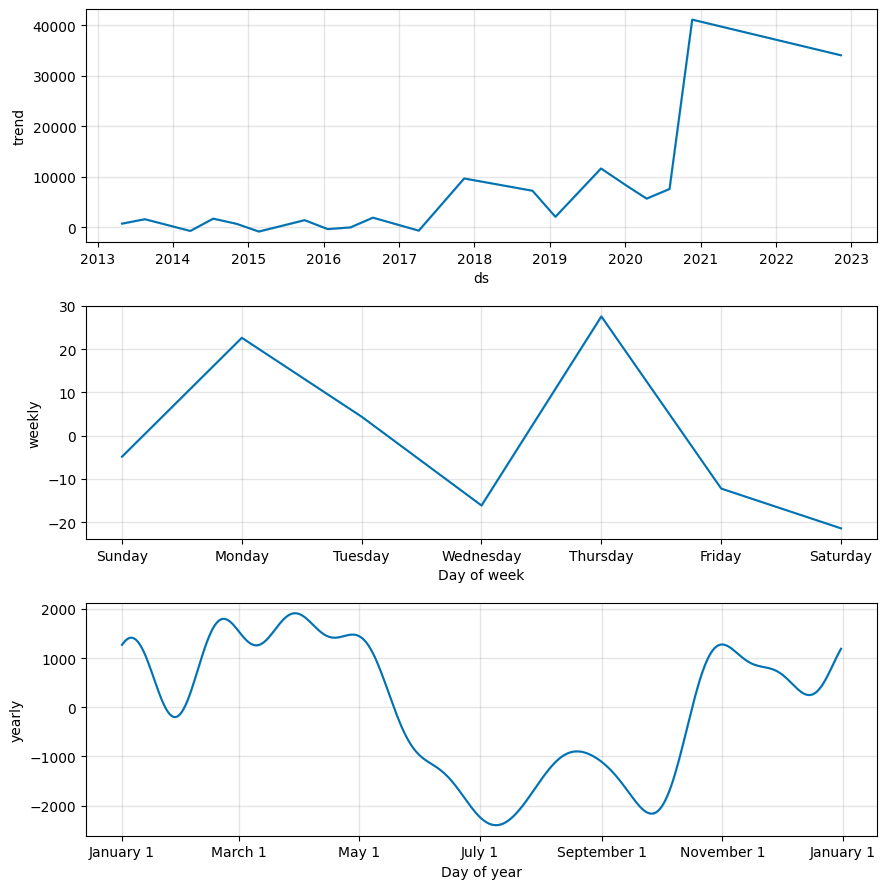

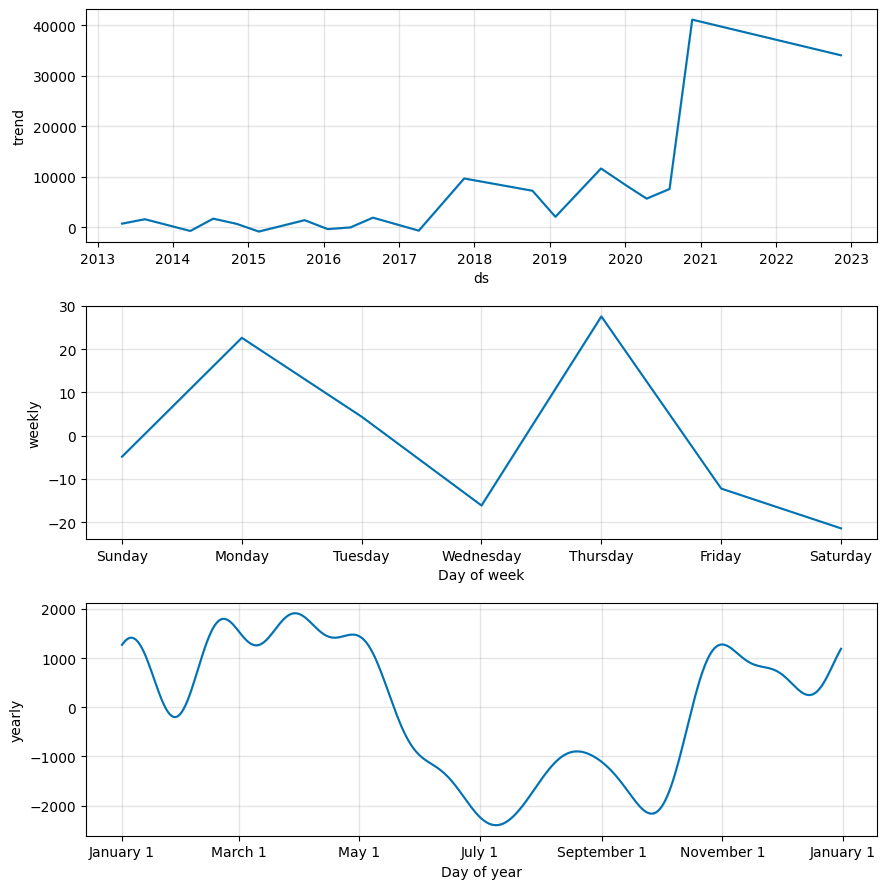

In [33]:
model.plot_components(forecast)

In [38]:
with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(model))  # Save model